<span style='font-family:"Times New Roman"'><font size="3">ML-zoomcamp Data talks cours 4 : </font></span>
<br />
<br />
<br />
<br />
<span style='font-family:"Times New Roman"'><div align="center"><font size="6">**Evaluation du modèle**</font></div></span>
<br /><br />
<span style='font-family:"Times New Roman"'><font size="5"><div align="right">*2 - 9 oct 2023*</div></font></span>
<br />
[cours](https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master/04-evaluation)<br />
[ennoncé du devoir](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2023/04-evaluation/homework.md)</font></span></div>
<br />
_____
<span style='color:blue'></span>
<br />
<br />

Note: sometimes your answer doesn't match one of the options exactly. That's fine. Select the option that's closest to your solution.

In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with wget:

wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

We'll work with the MSRP variable, and we'll transform it to a classification task.

For the rest of the homework, you'll need to use only these columns:

    Make,
    Model,
    Year,
    Engine HP,
    Engine Cylinders,
    Transmission Type,
    Vehicle Style,
    highway MPG,
    city mpg
    MSRP


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

Data preparation

    Keep only the columns above
    Lowercase the column names and replace spaces with underscores
    Fill the missing values with 0
    Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [3]:
df = df[[
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df['above_average'] = df['msrp'] > (df['msrp'].mean())
df['above_average'] = df['above_average'].astype(int)
del df['msrp']

df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

# Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score and compute AUC with the above_average variable
    Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

    engine_hp
    engine_cylinders
    highway_mpg
    city_mpg


In [6]:
num = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
cat = ['make', 'model', 'transmission_type', 'vehicle_style']

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [8]:
roc_value = []
col = []
X_train = df_train[num]
for feature in X_train.columns :
    model = LogisticRegression()
    model.fit(X_train[feature].to_frame(), y_train)
    
    y_score = model.predict_proba(X_train[feature].to_frame())
    
    roc_value.append(roc_auc_score(y_train, y_score[:, 1]))
    col.append(feature)
                     
pd.DataFrame(index = col, data = roc_value, columns = ['roc_value']).sort_values('roc_value', axis=0, ascending=False)

,roc_value
engine_hp,0.917103
engine_cylinders,0.766116
city_mpg,0.673424
highway_mpg,0.633059


# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.678
    0.779
    0.878
    0.979


In [9]:
from sklearn.feature_extraction import DictVectorizer
dv = dv = DictVectorizer(sparse=False)

In [10]:
# entraînement du modèle

train_dict = df_train[cat + num].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# validation

val_dict = df_val[cat + num].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)

0.9818269208660323

# Question 3: Precision and Recall

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.28
    0.48
    0.68
    0.88


In [11]:
#from sklearn.metrics import precision_recall_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score)

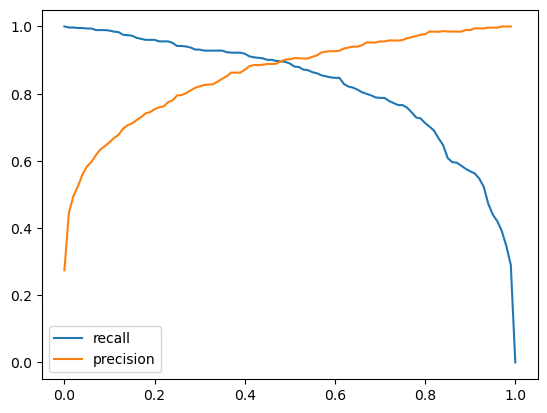

In [13]:
thresholds = np.linspace(0, 1, 101)

acc = []
prc = []
rec = []

for t in thresholds:
    score_acc = accuracy_score(y_val, y_pred >= t)
    score_prc = precision_score(y_val, y_pred>= t, zero_division=np.nan)
    score_rec = recall_score(y_val, y_pred >= t)
    #print('%.2f %.3f %.3f' % (t, score_acc, score_prc))
    acc.append(score_acc)
    prc.append(score_prc)
    rec.append(score_rec)
    
plt.plot(thresholds, rec, label='recall')
plt.plot(thresholds, prc, label='precision')


plt.legend()
plt.show()

# Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1: F1 = 2.(P.R) / (P+R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

    0.12
    0.32
    0.52
    0.72


In [14]:
from sklearn.metrics import f1_score

0.00 0.431
0.01 0.616
0.02 0.662
0.03 0.687
0.04 0.716
0.05 0.735
0.06 0.746
0.07 0.760
0.08 0.773
0.09 0.780
0.10 0.788
0.11 0.796
0.12 0.802
0.13 0.812
0.14 0.819
0.15 0.822
0.16 0.826
0.17 0.831
0.18 0.837
0.19 0.839
0.20 0.845
0.21 0.846
0.22 0.848
0.23 0.856
0.24 0.857
0.25 0.862
0.26 0.863
0.27 0.866
0.28 0.869
0.29 0.871
0.30 0.873
0.31 0.874
0.32 0.875
0.33 0.875
0.34 0.880
0.35 0.884
0.36 0.886
0.37 0.891
0.38 0.891
0.39 0.891
0.40 0.894
0.41 0.896
0.42 0.897
0.43 0.896
0.44 0.896
0.45 0.894
0.46 0.894
0.47 0.893
0.48 0.896
0.49 0.898
0.50 0.896
0.51 0.893
0.52 0.892
0.53 0.888
0.54 0.887
0.55 0.886
0.56 0.887
0.57 0.887
0.58 0.887
0.59 0.886
0.60 0.885
0.61 0.886
0.62 0.878
0.63 0.875
0.64 0.875
0.65 0.871
0.66 0.869
0.67 0.869
0.68 0.867
0.69 0.863
0.70 0.863
0.71 0.863
0.72 0.859
0.73 0.855
0.74 0.851
0.75 0.852
0.76 0.849
0.77 0.842
0.78 0.833
0.79 0.833
0.80 0.824
0.81 0.820
0.82 0.811
0.83 0.795
0.84 0.781
0.85 0.752
0.86 0.743
0.87 0.742
0.88 0.734
0.89 0.729
0.90 0.722

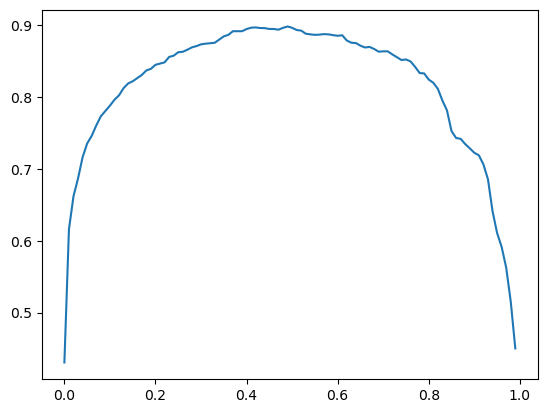

In [15]:
f1 = []
for t in thresholds:
    score = f1_score(y_val, y_pred >= t, zero_division=np.nan)
    print('%.2f %.3f' % (t, score))
    f1.append(score)
    
plt.plot(thresholds, f1, label='f1_score')

# Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

    0.003
    0.030
    0.090
    0.140


In [16]:
def train(df_full_train, y_full_train, C=1.0):
    dicts = df_train[cat + num].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [17]:
dv, model = train(df_train, y_train, C=0.001)

In [18]:
def predict(df, dv, model):
    dicts = df[cat + num].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [19]:
y_pred = predict(df_val, dv, model)

In [20]:
from sklearn.model_selection import KFold

In [21]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [22]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [23]:
from sklearn.metrics import auc

In [24]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print('%.3f' % (auc))

0.982
0.983
0.984
0.982
0.988


In [25]:
print ('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.984 +- 0.002


# Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

    Iterate over the following C values: [0.01, 0.1, 0.5, 10]
    Initialize KFold with the same parameters as previously
    Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

    0.01
    0.1
    0.5
    10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [26]:
n_splits = 5
C = (0.01, 0.1, 0.5, 10)

for i in C:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=i)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (i, np.mean(scores), np.std(scores)))

C=0.01 0.938 +- 0.002
C=0.1 0.973 +- 0.003
C=0.5 0.982 +- 0.002
C=10 0.987 +- 0.002


In [27]:
!pip install tqdm
from tqdm.auto import tqdm

In [28]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.938 +- 0.002
C=0.1 0.973 +- 0.003
C=0.5 0.982 +- 0.002
C=10 0.987 +- 0.002


In [29]:
from sklearn.metrics import (confusion_matrix)

cf_matrix = confusion_matrix(y_val, y_pred>= 0.5)
print(cf_matrix)
print('Test accuracy = ', accuracy_score(y_val, y_pred>= 0.5))

[[1344   42]
 [  46  474]]
Test accuracy =  0.9538300104931794


# Submit the results<br />

* Submit your results [here](https://forms.gle/E7Fa3WuBw3HkPQYg6): <br />
    If your answer doesn't match options exactly, select the closest one.<br />
    You can submit your solution multiple times. In this case, only the last submission will be used<br /><br />

* Deadline<br />
    The deadline for submitting is October 9 (Monday), 23:00 CET. After that the form will be closed.